#### Binary Classification of MAIT/iNKT Cells
Classify cell type (MAIT/iNKT) of a given CDR3 sequence using different machine/deep learning models and compare the results.
The input CDR3 sequences are either embedded using CVC or converted to one-hot encoding.

In [3]:
cd ..

/home/romi/projects/cvc


In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
import os, sys
import collections
import tqdm
import pandas as pd
import numpy as np
import seaborn as sns
import lab_notebooks.utils
import torch

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

SRC_DIR = "cvc"
assert os.path.isdir(SRC_DIR), f"Cannot find src dir: {SRC_DIR}"
sys.path.append(SRC_DIR)
from cvc import model_utils
from lab_notebooks.utils import SC_TRANSFORMER, TRANSFORMER, DEVICE, DATA_DIR
from single_cell_research import cvc_sequencing as cs
MODEL_DIR = os.path.join(SRC_DIR, "models")
sys.path.append(MODEL_DIR)

FILT_EDIT_DIST = True

PLOT_DIR = os.path.join(os.path.dirname(SRC_DIR), "plots/CDR3_data_plots")
if not os.path.isdir(PLOT_DIR):
    os.makedirs(PLOT_DIR)
PLOT_DIR

'plots/CDR3_data_plots'

In [6]:
DEVICE

device(type='cuda', index=0)

#### Load Data

In [243]:
# to load the embeddings from csv
load_csv = False
PLOT_SC = False # true for single cell data, false for TRA/TRB
CHAIN= 'TRA' # 'TRA' or 'TRB'
# roc_auc_nn = {} # to save results

In [244]:
# load data, make sure to have V/J Gene of CDR3 sequence - below the data came from different datasets
# https:/ls e/www.10xgenomics.com/resources/datasets/nsclc-tumor-tcr-enrichment-from-amplified-c-dna-1-standard-2-2-0
data_dir_1 = DATA_DIR + "10x_nsclc_tra_trb_df.csv"
# https://www.10xgenomics.com/resources/datasets/20-k-bone-marrow-mononuclear-cells-bmmn-cs-5-ht-v-2-0-2-high-6-1-0
data_dir_2 = DATA_DIR + "20k_BMMNC_vdj_t_filtered_contig_annotations.csv"
# https://www.10xgenomics.com/resources/datasets/pbm-cs-of-a-healthy-donor-tcr-enrichment-from-amplified-c-dna-1-standard-3-0-0
data_dir_3 = DATA_DIR + "pbmc2_t_filtered_contig_annotations.csv"
# https://www.10xgenomics.com/resources/datasets/10-k-human-pbm-cs-5-v-2-0-chromium-x-2-standard-6-1-0
data_dir_4 = DATA_DIR + "10k_pbmc_vdj_t_filtered_contig_annotations.csv"
# https://www.10xgenomics.com/resources/datasets/cd-8-plus-t-cells-of-healthy-donor-1-1-standard-3-0-2
data_dir_5 = DATA_DIR + "cd8_t_filtered_contig_annotations_d1.csv"
# https://www.10xgenomics.com/resources/datasets/cd-8-plus-t-cells-of-healthy-donor-2-1-standard-3-0-2
data_dir_6 = DATA_DIR + "cd8_t_filtered_contig_annotations_d2.csv"
# https://www.10xgenomics.com/resources/datasets/cd-8-plus-t-cells-of-healthy-donor-3-1-standard-3-0-2
data_dir_7 = DATA_DIR + "cd8_t_filtered_contig_annotations_d3.csv"
# https://www.10xgenomics.com/resources/datasets/cd-8-plus-t-cells-of-healthy-donor-4-1-standard-3-0-2
data_dir_8 = DATA_DIR + "cd8_t_filtered_contig_annotations_d4.csv"

In [245]:
def sc_load_data(data_dir):
    sc_data = pd.read_csv(data_dir, usecols=["barcode", "contig_id", "chain", "v_gene", "j_gene", "c_gene", "cdr3", "cdr3_nt"], engine="pyarrow")
    sc_data = sc_data[sc_data.cdr3 != "None"]
    return sc_data

In [246]:
# read data
sc_data_1 = sc_load_data(data_dir_1)
sc_data_2 = sc_load_data(data_dir_2)
sc_data_3 = sc_load_data(data_dir_3)
sc_data_4 = sc_load_data(data_dir_4)
sc_data_5 = sc_load_data(data_dir_5)
sc_data_6 = sc_load_data(data_dir_6)
sc_data_7 = sc_load_data(data_dir_7)
sc_data_8 = sc_load_data(data_dir_8)

In [247]:
len(sc_data_1), len(sc_data_2), len(sc_data_3), len(sc_data_4), len(sc_data_5), len(sc_data_6), len(sc_data_7), len(sc_data_8)

(3643, 19737, 6037, 14632, 123862, 191643, 321467, 233142)

#### Preprocess Data - Label MAIT/iNKT Cells

In [248]:
MAIT_v_gene='TRAV1-2'
MAIT_j_gene = ['TRAJ33', 'TRAJ20', 'TRAJ12']
iNKT_v_gene = 'TRAV10'
iNKT_j_gene = 'TRAJ18'

v_gene_to_use = MAIT_v_gene #iNKT_v_gene
j_gene_to_use = MAIT_j_gene #iNKT_j_gene
cell_label_to_use = 'MAIT_cell'#'iNKT_cell'

In [249]:
def label_iNKT_MAIT(sc_df, v_gene_list, j_gene_list, cell_label):
    cell_label_not = 'non-'+cell_label
    sc_df_tra = sc_df[sc_df['chain'] == 'TRA']

    # create "MAIT_cell" column if the v_gene is "TRAV1-2" and j_gene is TRAJ33 or TRAJ20 or TRAJ12
    sc_df_tra[cell_label] = np.where((sc_df_tra['v_gene'] == v_gene_list) &
                                     (sc_df_tra['j_gene'].str.contains('|'.join(j_gene_list))), cell_label, cell_label_not)

    # extract the list of barcodes from the dataframe that are MAIT cells
    true_label_barcodes = sc_df_tra[sc_df_tra[cell_label] == cell_label]['barcode'].tolist()

    # create a column in embed_data that is MAIT_cell if the barcode is in the MAIT_barcodes list, and non-MAIT_cell otherwise
    sc_df[cell_label] = np.where(sc_df['barcode'].isin(true_label_barcodes), cell_label, cell_label_not)
    return sc_df

In [250]:
sc_data_1_labeled = label_iNKT_MAIT(sc_data_1, v_gene_to_use, j_gene_to_use, cell_label_to_use)
sc_data_2_labeled = label_iNKT_MAIT(sc_data_2, v_gene_to_use, j_gene_to_use, cell_label_to_use)
sc_data_3_labeled = label_iNKT_MAIT(sc_data_3, v_gene_to_use, j_gene_to_use, cell_label_to_use)
sc_data_4_labeled = label_iNKT_MAIT(sc_data_4, v_gene_to_use, j_gene_to_use, cell_label_to_use)
sc_data_5_labeled = label_iNKT_MAIT(sc_data_5, v_gene_to_use, j_gene_to_use, cell_label_to_use)
sc_data_6_labeled = label_iNKT_MAIT(sc_data_6, v_gene_to_use, j_gene_to_use, cell_label_to_use)
sc_data_7_labeled = label_iNKT_MAIT(sc_data_7, v_gene_to_use, j_gene_to_use, cell_label_to_use)
sc_data_8_labeled = label_iNKT_MAIT(sc_data_8, v_gene_to_use, j_gene_to_use, cell_label_to_use)

/tmp/ipykernel_1211/2974906851.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sc_df_tra[cell_label] = np.where((sc_df_tra['v_gene'] == v_gene_list) &
/tmp/ipykernel_1211/2974906851.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sc_df_tra[cell_label] = np.where((sc_df_tra['v_gene'] == v_gene_list) &
/tmp/ipykernel_1211/2974906851.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

In [251]:
if PLOT_SC == False:
# take only chain
    sc_data_1_labeled_by_chain = sc_data_1_labeled[sc_data_1_labeled.chain == CHAIN]
    sc_data_2_labeled_by_chain = sc_data_2_labeled[sc_data_2_labeled.chain == CHAIN]
    sc_data_3_labeled_by_chain = sc_data_3_labeled[sc_data_3_labeled.chain == CHAIN]
    sc_data_4_labeled_by_chain = sc_data_4_labeled[sc_data_4_labeled.chain == CHAIN]
    sc_data_5_labeled_by_chain = sc_data_5_labeled[sc_data_5_labeled.chain == CHAIN]
    sc_data_6_labeled_by_chain = sc_data_6_labeled[sc_data_6_labeled.chain == CHAIN]
    sc_data_7_labeled_by_chain = sc_data_7_labeled[sc_data_7_labeled.chain == CHAIN]
    sc_data_8_labeled_by_chain = sc_data_8_labeled[sc_data_8_labeled.chain == CHAIN]
    # concat all
    sc_data_all_labeled = pd.concat([sc_data_1_labeled_by_chain, sc_data_2_labeled_by_chain, sc_data_3_labeled_by_chain, sc_data_4_labeled_by_chain, sc_data_5_labeled_by_chain, sc_data_6_labeled_by_chain, sc_data_7_labeled_by_chain, sc_data_8_labeled_by_chain])
else:
    sc_data_1_labeled_concat = cs.concatenate_labels(sc_data_1_labeled, label_column='MAIT_cell', barcodes_column='barcode')
    sc_data_2_labeled_concat = cs.concatenate_labels(sc_data_2_labeled, label_column='MAIT_cell', barcodes_column='barcode')
    sc_data_3_labeled_concat = cs.concatenate_labels(sc_data_3_labeled, label_column='MAIT_cell', barcodes_column='barcode')
    sc_data_4_labeled_concat = cs.concatenate_labels(sc_data_4_labeled, label_column='MAIT_cell', barcodes_column='barcode')
    sc_data_5_labeled_concat = cs.concatenate_labels(sc_data_5_labeled, label_column='MAIT_cell', barcodes_column='barcode')
    sc_data_6_labeled_concat = cs.concatenate_labels(sc_data_6_labeled, label_column='MAIT_cell', barcodes_column='barcode')
    sc_data_7_labeled_concat = cs.concatenate_labels(sc_data_7_labeled, label_column='MAIT_cell', barcodes_column='barcode')
    sc_data_8_labeled_concat = cs.concatenate_labels(sc_data_8_labeled, label_column='MAIT_cell', barcodes_column='barcode')
    # concat all
    sc_data_all_labeled = pd.concat([sc_data_1_labeled_concat, sc_data_2_labeled_concat, sc_data_3_labeled_concat, sc_data_4_labeled_concat, sc_data_5_labeled_concat, sc_data_6_labeled_concat, sc_data_7_labeled_concat, sc_data_8_labeled_concat])

In [252]:
sc_data_all_labeled

,barcode,contig_id,chain,v_gene,j_gene,c_gene,cdr3,cdr3_nt,MAIT_cell
1,AAGACCTCATTTGCCC-1,AAGACCTCATTTGCCC-1_contig_3,TRA,TRAV21,TRAJ52,TRAC,CAVAPAGGTSYGKLTF,TGTGCTGTGGCCCCTGCTGGTGGTACTAGCTATGGAAAGCTGACATTT,non-MAIT_cell
3,AAGGCAGCAAGTAATG-1,AAGGCAGCAAGTAATG-1_contig_2,TRA,TRAV13-2,TRAJ28,TRAC,CAENDSGAGSYQLTF,TGTGCAGAGAATGACTCTGGGGCTGGGAGTTACCAACTCACTTTC,non-MAIT_cell
4,AAGGCAGCAAGTAATG-1,AAGGCAGCAAGTAATG-1_contig_3,TRA,TRAV34,TRAJ38,TRAC,CGADQGWQQP*ADL,TGTGGAGCAGACCAAGGCTGGCAACAACCGTAAGCTGATTTG,non-MAIT_cell
6,ATAAGAGCAAAGCGGT-1,ATAAGAGCAAAGCGGT-1_contig_6,TRA,TRAV8-1,TRAJ40,TRAC,CAVNGEGTYKYIF,TGTGCCGTGAATGGTGAGGGAACCTACAAATACATCTTT,non-MAIT_cell
7,CCTCAGTTCCGCATAA-1,CCTCAGTTCCGCATAA-1_contig_2,TRA,TRAV26-1,TRAJ48,TRAC,CIVRSSNFGNEKLTF,TGCATCGTCAGGTCATCTAACTTTGGAAATGAGAAATTAACCTTT,non-MAIT_cell
...,...,...,...,...,...,...,...,...,...
309835,TTTGTCATCTGCAGTA-1,TTTGTCATCTGCAGTA-1_contig_1,TRA,TRAV4,TRAJ37,TRAC,CLVALSGNTGKLIF,TGCCTCGTGGCCCTCTCTGGCAACACAGGCAAACTAATCTTT,non-MAIT_cell
309840,TTTGTCATCTGGTTCC-4,TTTGTCATCTGGTTCC-4_contig_1,TRA,TRAV6,TRAJ4,TRAC,CALAGGYNKLIF,TGTGCTCTAGCCGGTGGCTACAATAAGCTGATTTTT,non-MAIT_cell
309846,TTTGTCATCTTCTGGC-6,TTTGTCATCTTCTGGC-6_contig_1,TRA,TRAV27,TRAJ23,TRAC,CRSSR*PGRKAYLRT,TGCAGGAGCTCTCGGTAACCAGGGAGGAAAGCTTATCTTCGGACA,non-MAIT_cell
309847,TTTGTCATCTTGACGA-5,TTTGTCATCTTGACGA-5_contig_1,TRA,TRAV21,TRAJ50,TRAC,CAVDLMKTSYDKVIF,TGTGCTGTCGATCTCATGAAAACCTCCTACGACAAGGTGATATTT,non-MAIT_cell


In [253]:
collections.Counter(sc_data_all_labeled[cell_label_to_use])

Counter({'non-MAIT_cell': 372632, 'MAIT_cell': 8057})

In [254]:
# drop duplicates
sc_data_all_labeled = sc_data_all_labeled.drop_duplicates(subset=['cdr3'])
# drop nan
sc_data_all_labeled = sc_data_all_labeled.dropna(subset=['cdr3'])

In [255]:
collections.Counter(sc_data_all_labeled[cell_label_to_use])

Counter({'non-MAIT_cell': 98941, 'MAIT_cell': 1266})

In [256]:
# export data
if PLOT_SC == False:
    sc_data_all_labeled.to_csv('./CDR3_data/sc_data_MAIT_TRA_8_datasets.csv', index=False)
else:
    sc_data_all_labeled.to_csv('./CDR3_data/sc_data_MAIT_sc_8_datasets.csv', index=False)

#### Split cell-types into equal groups

In [257]:
cell_label = cell_label_to_use
cell_label_not = 'non-'+cell_label

In [258]:
cell_count = collections.Counter(sc_data_all_labeled[cell_label])[cell_label]
NUM_TO_SAMPLE = cell_count
# sample equal number of private and public
if cell_label == 'MAIT_cell':
    true_sample = sc_data_all_labeled.query('MAIT_cell == "MAIT_cell"').sample(NUM_TO_SAMPLE)
    false_sample = sc_data_all_labeled.query('MAIT_cell == "non-MAIT_cell"').sample(NUM_TO_SAMPLE)
elif cell_label == 'iNKT_cell':
    true_sample = sc_data_all_labeled.query('iNKT_cell == "iNKT_cell"').sample(NUM_TO_SAMPLE)
    false_sample = sc_data_all_labeled.query('iNKT_cell == "non-iNKT_cell"').sample(NUM_TO_SAMPLE)
else:
    raise ValueError('')

In [259]:
# join public and private samples
cell_type_data_sample = pd.concat([true_sample, false_sample])
cell_type_data_sample

,barcode,contig_id,chain,v_gene,j_gene,c_gene,cdr3,cdr3_nt,MAIT_cell
12173,ACCCACTTCATGTCTT-40,ACCCACTTCATGTCTT-40_contig_3,TRA,TRAV1-2,TRAJ33,TRAC,CAVSPPDSNYQLIW,TGTGCTGTGAGTCCTCCTGATAGCAACTATCAGTTAATCTGG,MAIT_cell
5056,CACATTTCAGCTCCGA-1,CACATTTCAGCTCCGA-1_contig_1,TRA,TRAV1-2,TRAJ12,TRAC,CAAMDSSYKLIF,TGTGCTGCGATGGATAGCAGCTATAAATTGATCTTC,MAIT_cell
85459,TCTATTGGTGTGCCTG-1,TCTATTGGTGTGCCTG-1_contig_2,TRA,TRAV1-2,TRAJ33,TRAC,CAVRGLMDSNYQLIW,TGTGCTGTGAGAGGCCTCATGGATAGCAACTATCAGTTAATCTGG,MAIT_cell
64161,CGACTTCGTCAGAGGT-22,CGACTTCGTCAGAGGT-22_contig_2,TRA,TRAV1-2,TRAJ20,TRAC,CAVREGSSNDYKLSF,TGTGCTGTGAGAGAGGGGTCTTCTAACGACTACAAGCTCAGCTTT,MAIT_cell
110874,CGCGGTATCCCACTTG-40,CGCGGTATCCCACTTG-40_contig_5,TRA,TRAV13-1,TRAJ7,TRAC,CAASILGTTDSLL,TGTGCAGCAAGTATACTGGGAACAACAGACTCGCTTTTG,MAIT_cell
...,...,...,...,...,...,...,...,...,...
78245,CTACATTCATTCGACA-23,CTACATTCATTCGACA-23_contig_4,TRA,TRAV39,TRAJ27,TRAC,CAVDIEGKSTF,TGTGCCGTGGACATAGAAGGCAAATCAACCTTT,non-MAIT_cell
216102,CAGCATATCACATACG-8,CAGCATATCACATACG-8_contig_1,TRA,TRAV13-1,TRAJ27,TRAC,CAAPTNTNAGKSTF,TGTGCAGCACCCACCAACACCAATGCAGGCAAATCAACCTTT,non-MAIT_cell
6471,TAGCCGGTCCTGCCAT-1,TAGCCGGTCCTGCCAT-1_contig_1,TRA,TRAV39,TRAJ53,TRAC,CAVDMGSGGSNYKLTF,TGTGCCGTGGACATGGGAAGTGGAGGTAGCAACTATAAACTGACATTT,non-MAIT_cell
169038,CCCAGTTGTTAAGAAC-8,CCCAGTTGTTAAGAAC-8_contig_2,TRA,TRAV14DV4,TRAJ9,TRAC,CAMRGRTGGFKTIF,TGTGCAATGAGAGGGAGGACTGGAGGCTTCAAAACTATCTTT,non-MAIT_cell


In [260]:
cell_type_data_sample.to_csv('./CDR3_data/sc_data_MAIT_8_datasets_sampled.csv', index=False)

In [261]:
# convert label column to numpy array
cell_label_array = cell_type_data_sample[cell_label].to_numpy()
print(cell_label_array)

['MAIT_cell' 'MAIT_cell' 'MAIT_cell' ... 'non-MAIT_cell' 'non-MAIT_cell'
 'non-MAIT_cell']


In [262]:
# rename cdr3 column to Sequences for embedding creation
cell_type_data_sample.rename(columns={"cdr3": "Sequences"}, inplace=True)

In [263]:
from cvc.embbeding_wrapper import EmbeddingWrapper
# Create embeddings
# when using TRANSFORMER, max_len=64, batch_size=256
embed_wrap = EmbeddingWrapper(SC_TRANSFORMER, DEVICE, sequences_df=cell_type_data_sample, batch_size=128, method="mean", layers=[-1], pbar=True, max_len=120)
embed_wrap.embeddings.shape

Some weights of the model checkpoint at /home/romi/projects/cvc/output_dir_singlecell_v2 were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/20 [00:00<?, ?it/s]

(2532, 768)

In [264]:
# create anndata object
embeddings_adata = embed_wrap.create_anndata()
# embeddings df
df_embeddings = pd.DataFrame(embed_wrap.embeddings)

/opt/conda/envs/tcrbert/lib/python3.9/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


In [265]:
# add MAIT label to dataframe
df_embeddings_with_label = df_embeddings
df_embeddings_with_label[cell_label]=list(embeddings_adata.obs[cell_label])
df_embeddings_with_label['Sequences']=list(embeddings_adata.obs['Sequences'])

In [266]:
file_embedding_path = './' + cell_label + '_sc_data_TRA_embeddings_8_datasets.csv'
# export embeddings to csvֿ
df_embeddings_with_label.to_csv(DATA_DIR + file_embedding_path)

In [267]:
# load from csv
if load_csv==True:
    df_embeddings_with_label = pd.read_csv("./CDR3_data/MAIT_cell_sc_data_embeddings_8_datasets.csv")
    df_embeddings_with_label = df_embeddings_with_label.drop_duplicates(subset=['Sequences'])
    # remove Public_Private_Label co\lumn
    # df_embeddings_with_label = df_embeddings_with_label.drop(columns=['Public_Private_Label'])
cell_type_embeddings = df_embeddings_with_label.iloc[:,1:-2].to_numpy()
cell_type_label_array= df_embeddings_with_label.MAIT_cell.to_numpy()

In [268]:
# drop duplicates Sequences
df_embeddings_with_label = df_embeddings_with_label.drop_duplicates(subset=['Sequences'])
collections.Counter(df_embeddings_with_label.MAIT_cell)

Counter({'MAIT_cell': 1266, 'non-MAIT_cell': 1266})

#### Binary Classification Utils

In [269]:
TRAIN_RATIO = 0.8

def split_train_test(embeddings, embedding_labels):
    #import pdb; pdb.set_trace()
    # The data will be divided into 80% training 20% validation
    idx_train = int(len(embeddings) * TRAIN_RATIO)

    indices = np.arange(embeddings.shape[0])

    # Shuffle data
    np.random.shuffle(indices)

    # Separate the images and the labels
    embeddings_shuffle = embeddings[indices] 
    embedding_labels_shuffle = embedding_labels[indices]

    # Split to train and validation
    train_embeddings = embeddings_shuffle[:idx_train]
    train_labels = embedding_labels_shuffle[:idx_train]
    validation_embeddings = embeddings_shuffle[idx_train:]
    validation_labels = embedding_labels_shuffle[idx_train:]
    
    return train_embeddings, train_labels, validation_embeddings, validation_labels

In [270]:
embeddings = cell_type_embeddings
embedding_labels = cell_type_label_array
print("shape of embeddings: {}\nshape of embedding_labels: {}".format(embeddings.shape,embedding_labels.shape))

shape of embeddings: (2532, 767)
shape of embedding_labels: (2532,)


In [271]:
train_embeddings, embed_train_labels, validation_embeddings, embed_validation_labels = split_train_test(embeddings, embedding_labels)
train_embeddings.shape, embed_train_labels.shape, validation_embeddings.shape, embed_validation_labels.shape

((2025, 767), (2025,), (507, 767), (507,))

In [272]:
labels = [cell_label, cell_label_not]
label_to_id = {label: i for i, label in enumerate(labels)}
numeric_train_labels = [label_to_id[label] for label in embed_train_labels]
numeric_valid_labels = [label_to_id[label] for label in embed_validation_labels]

In [273]:
# check that the data is even
collections.Counter(numeric_valid_labels), collections.Counter(numeric_train_labels)

(Counter({0: 244, 1: 263}), Counter({1: 1003, 0: 1022}))

##### One-Hot Encoding

In [36]:
# Import Dependencies 
import pandas as pd
import numpy as np
import torch.nn.functional as F

# Function to encode sequences
def encode_seq(sequence, max_cdr3_len):
    alphabet = ['A', 'C', 'D', 'E', 'F', 'G','H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y', "*", '|']
    char_to_int = dict((c, i) for i, c in enumerate(alphabet))
    integer_encoded = [char_to_int[char] for char in sequence]
    
    # one hot encode
    integer_encoded = torch.tensor(integer_encoded)
    integer_encoded = F.one_hot(integer_encoded, num_classes=len(alphabet))
    
    # pad integer_encoded tensor first dim with zeros up to max_cdr3_len
    integer_encoded = F.pad(integer_encoded, (0,0,0, max_cdr3_len - len(integer_encoded)))
    
    integer_encoded = integer_encoded.numpy()

    return integer_encoded

In [37]:
# extract sequences
cdr3_sequences = df_embeddings_with_label['Sequences']#tcrb_data_sample['Sequences']
sequences_labels = cell_type_label_array
max_cdr3_len = cdr3_sequences.apply(len).max()
max_cdr3_len

26

In [38]:
# split data into train/test
train_seqs, train_labels, validation_seqs, validation_labels = split_train_test(cdr3_sequences.to_numpy(), sequences_labels)
print("shape of training set: {}\nshape of validation set: {}".format(train_seqs.shape, validation_seqs.shape))

shape of training set: (2025,)
shape of validation set: (507,)


In [39]:
numeric_train_onehot_labels = [label_to_id[label] for label in train_labels]
numeric_valid_onehot_labels = [label_to_id[label] for label in validation_labels]

In [40]:
# encode amino acid sequences to one hot vector
encoded_train_seqs = pd.Series(train_seqs).apply(lambda x: encode_seq(x, max_cdr3_len))
encoded_validation_seqs = pd.Series(validation_seqs).apply(lambda x: encode_seq(x, max_cdr3_len))

In [41]:
# Stack list(encoded_train_seqs) in dim 0
train_seqs_stack = np.stack(encoded_train_seqs, axis=0)
valid_seqs_stack = np.stack(encoded_validation_seqs, axis=0)
train_seqs_stack.shape, valid_seqs_stack.shape

((2025, 26, 22), (507, 26, 22))

In [42]:
# reshape train/validation tensors
train_seqs_stack = train_seqs_stack.reshape(train_seqs_stack.shape[0], -1)
valid_seqs_stack = valid_seqs_stack.reshape(valid_seqs_stack.shape[0], -1)
train_seqs_stack.shape, valid_seqs_stack.shape

((2025, 572), (507, 572))

#### xgBoost on Embeddings
Guide on xgBoost - https://towardsdatascience.com/beginners-guide-to-xgboost-for-classification-problems-50f75aac5390

In [45]:
# feature scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
train_embeddings = sc.fit_transform(train_embeddings)
validation_embeddings = sc.fit_transform(validation_embeddings)

In [46]:
# extract accuracy
accuracy_xgb, xgb_preds, xgb_classifier = \
    lab_notebooks.utils.xgb_classify(train_embeddings, numeric_train_labels, validation_embeddings, numeric_valid_labels)
accuracy_xgb

78.30374753451676

In [45]:
# plot the roc curve for the model
# get probabilities
probs = xgb_classifier.predict_proba(validation_embeddings)
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(numeric_valid_labels, probs[:, 1])
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

#### xgBoost on One-Hot Encoding

In [68]:
# apply xgb on onehot, extract accuracy
accuracy_xgb_onehot, xgb_preds_onehot, xgb_classifier_onehot =\
    lab_notebooks.utils.xgb_classify(train_seqs_stack, numeric_train_onehot_labels, valid_seqs_stack, numeric_valid_onehot_labels)

# get probabilities and roc
probs = xgb_classifier_onehot.predict_proba(valid_seqs_stack)
fpr_onehot_xgb, tpr_onehot_xgb, thresholds_onehot_xgb = roc_curve(numeric_valid_onehot_labels, probs[:, 1])
roc_auc_onehot_xgb = auc(fpr_onehot_xgb, tpr_onehot_xgb)

accuracy_xgb_onehot

70.21696252465483

#### Random Forest on Embeddings

In [ ]:
# Run with atom-ml
from atom import ATOMClassifier

df = pd.DataFrame(np.concatenate([train_embeddings, validation_embeddings], axis=0))
df['label'] = numeric_train_labels + numeric_valid_labels

atom = ATOMClassifier(df, y='label', n_rows=len(df), verbose=2)
atom.run(models=[
    "RF"
], metric="accuracy", n_trials=15)

#### LDA

In [110]:
# apply LDA
accuracy_lda, lda_preds, lda_classifier = lab_notebooks.utils.lda_classify(train_embeddings,numeric_train_labels, validation_embeddings, numeric_valid_labels)

In [111]:
# plot the roc curve for the model
# get probabilities
probs = lda_classifier.predict_proba(validation_embeddings)
fpr_lda, tpr_lda, thresholds_lda = roc_curve(numeric_valid_labels, probs[:, 1])
roc_auc_lda = auc(fpr_lda, tpr_lda)

accuracy_lda

69.2704495210022

#### LDA oneHot

In [117]:
# apply xgb on onehot, extract accuracy
accuracy_lda_onehot, lda_preds_onehot, lda_classifier_onehot =\
    lab_notebooks.utils.lda_classify(train_seqs_stack, numeric_train_onehot_labels, valid_seqs_stack, numeric_valid_onehot_labels)

probs_oh_lda = lda_classifier_onehot.predict_proba(valid_seqs_stack)
fpr_onehot_lda, tpr_onehot_lda, thresholds_onehot_lda = roc_curve(numeric_valid_onehot_labels, probs_oh_lda[:, 1])
roc_auc_onehot_lda = auc(fpr_onehot_lda, tpr_onehot_lda)

accuracy_lda_onehot

66.61753868828298

### Deep Neural Network

#### Deep Learning Model on Embeddings

In [274]:
# set flag to run with onehot
DNN_ONEHOT = 0

In [275]:
# defining dataset class
from torch.utils.data import Dataset, DataLoader
class dataset(Dataset):
    def __init__(self,x, y):
        # self.x = torch.tensor(x, dtype=torch.float32).to('cuda')
        # self.y = torch.tensor(y, dtype=torch.float32).to('cuda')
        self.x = torch.tensor(x, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
        self.length = self.x.shape[0]
        assert self.x.shape[0] == self.y.shape[0]
        
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]
    
    def __len__(self):
        return self.length

In [276]:
BATCH_SIZE = 256 #32

# create datasets
if DNN_ONEHOT==0:
    trainset = dataset(train_embeddings, numeric_train_labels)
    validset = dataset(validation_embeddings, numeric_valid_labels)
else:
    trainset = dataset(train_seqs_stack, numeric_train_onehot_labels)
    validset = dataset(valid_seqs_stack, numeric_valid_onehot_labels)

# DataLoader with 10 workers
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=10, pin_memory=True)
validloader = DataLoader(validset, batch_size=BATCH_SIZE, num_workers=10, pin_memory=True)

/opt/conda/envs/tcrbert/lib/python3.9/site-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [277]:
# defining the network
from torch import nn
from torch.nn import functional as F

class Net(nn.Module):
    def __init__(self, input_shape):
        super(Net,self).__init__()
        self.fc1 = nn.Linear(input_shape,128)
        self.fc2 = nn.Linear(128,32)
        self.fc3 = nn.Linear(32,1)
    
    def forward(self,x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x

# add some more regularization
class Net2_v2(nn.Module):
    def __init__(self, input_shape):
        super(Net2_v2,self).__init__()
        self.fc1 = nn.Linear(input_shape,128)
        self.fc2 = nn.Linear(128,32)
        self.fc3 = nn.Linear(32,1)
        self.dropout = nn.Dropout(0.5)
        self.batchnorm1 = nn.BatchNorm1d(128)
        self.batchnorm2 = nn.BatchNorm1d(32)

    def forward(self,x):
        x = torch.relu(self.fc1(x))
        x = self.batchnorm1(x)
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.batchnorm2(x)
        x = self.dropout(x)
        x = torch.sigmoid(self.fc3(x))
        return x

In [278]:
# hyper parameters
# learning_rate = 0.000001
learning_rate  = 0.00001

# set input shape
input_shape = train_embeddings.shape[1]
if DNN_ONEHOT:
    input_shape = train_seqs_stack.shape[1]

# Model , Optimizer, Loss
model = Net(input_shape=input_shape).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
loss_fn = nn.BCELoss()

In [279]:
def calculate_accuracy(y_pred, y_test):
    y_pred_tag = torch.round(y_pred)
    y_test = y_test.unsqueeze(1)
    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    return acc

In [280]:
def train_classify(model, trainloader, optimizer):
    epoch_loss = 0
    epoch_acc = 0
    count = 0
    model.train()
    for train_embedding, train_label in tqdm.notebook.tqdm(trainloader, total=len(trainloader)):
        # option to move train_embedding, train_label to gpu here
        # calculate output
        train_embedding, train_label =  train_embedding.to(DEVICE), train_label.to(DEVICE)
        output = model(train_embedding)
        
        # calculate loss
        loss = loss_fn(output, train_label.reshape(-1,1))
        
        # accuracy
        acc = calculate_accuracy(output, train_label)
        
        # backprop
        optimizer.zero_grad() 
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()
        count += len(train_label)
        
    return epoch_loss / len(trainloader), epoch_acc / len(trainloader)

In [281]:
def evaluate_classify(model, validloader): 
    epoch_loss = 0
    epoch_acc = 0
    count = 0
    model.eval()
    label_list = []
    pred_label_list = []
    with torch.no_grad(): 
        for valid_embedding, valid_label in tqdm.notebook.tqdm(validloader, total=len(validloader)):
            # option to move valid_embedding, valid_label to gpu here
            valid_embedding, valid_label = valid_embedding.to(DEVICE), valid_label.to(DEVICE)
            # calculate output
            output = model(valid_embedding)

            # calculate loss
            loss = loss_fn(output, valid_label.reshape(-1,1))

            # accuracy
            acc = calculate_accuracy(output, valid_label)
            
            # add to lists for confusion matrixv
            label_list.append(valid_label.cpu())
            pred_label_list.append(output.cpu())
            
            #acc = calculate_accuracy(output, valid_label)
            epoch_loss += loss.item()
            epoch_acc += acc.item()
            count += len(valid_label)
    return (epoch_loss / len(validloader), epoch_acc / len(validloader),
            torch.cat(label_list, dim=0), 
            torch.cat(pred_label_list, dim=0))

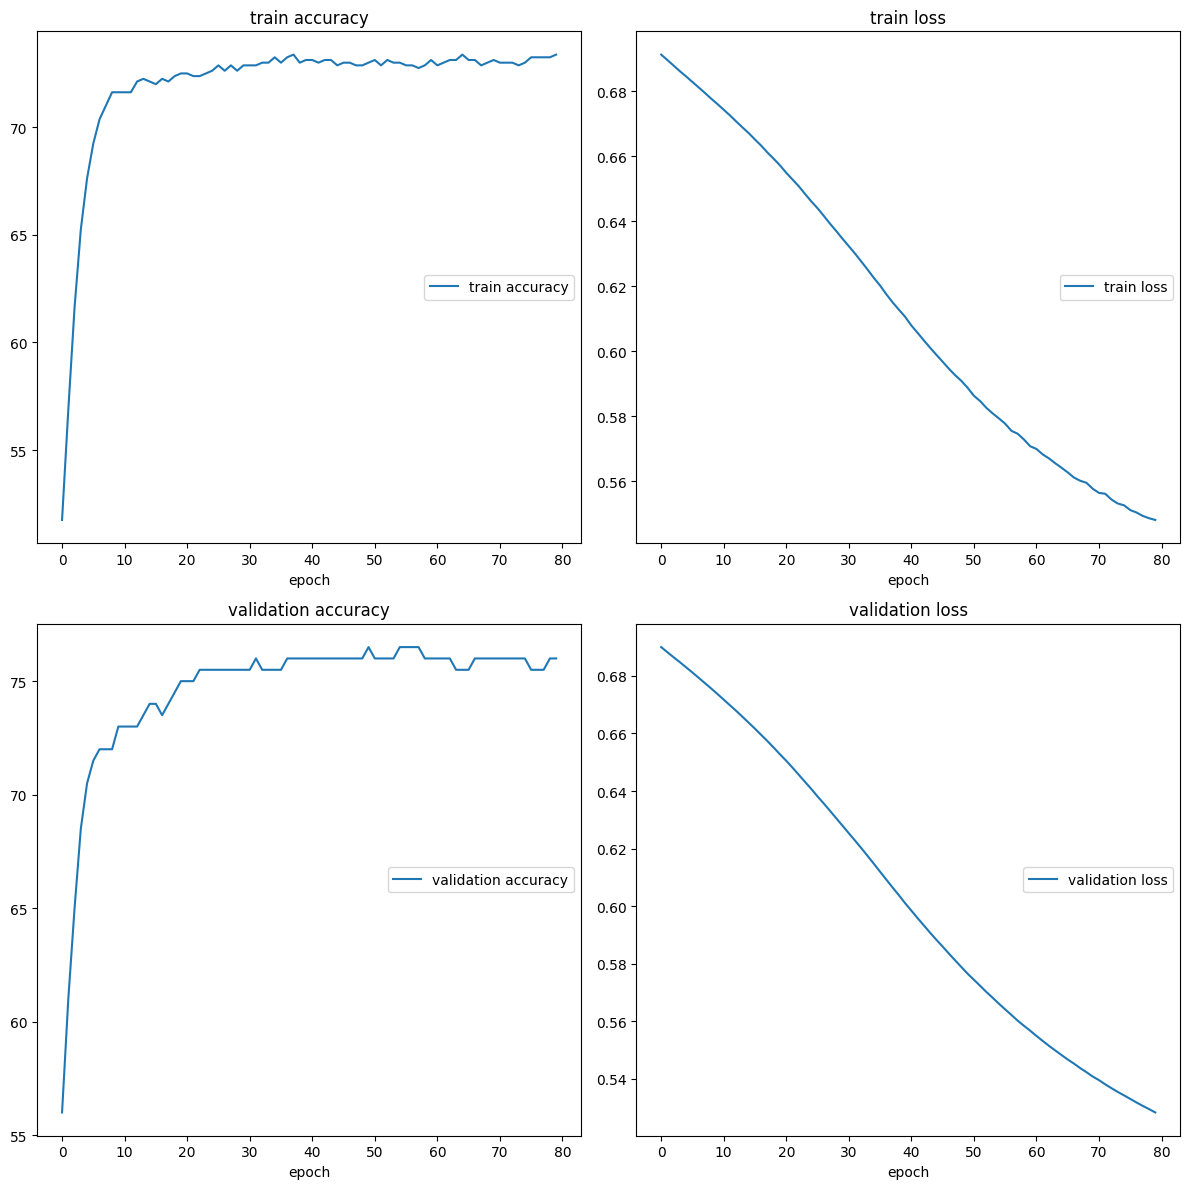

train accuracy
	train accuracy   	 (min:   51.750, max:   73.375, cur:   73.375)
train loss
	train loss       	 (min:    0.548, max:    0.691, cur:    0.548)
validation accuracy
	validation accuracy 	 (min:   56.000, max:   76.500, cur:   76.000)
validation loss
	validation loss  	 (min:    0.528, max:    0.690, cur:    0.528)


In [282]:
from livelossplot import PlotLosses

liveloss1_class = PlotLosses()
logs_class = {}
EPOCHS=80

for epoch in range(EPOCHS):
    print('starting epoch {}'.format(epoch))
    train_loss, train_acc = train_classify(model, trainloader, optimizer)
    print('Epoch {} of {}, Train Loss: {:.3f}'.format(
            epoch+1, EPOCHS, train_loss))
    
    print('Epoch {} of {}, Train Accuracy: {:.3f}'.format(
          epoch+1, EPOCHS, train_acc))
    
    logs_class['train loss'] = train_loss
    logs_class['train accuracy'] = train_acc

    valid_loss, valid_acc, label_list, pred_label_list  = evaluate_classify(model, validloader)
    print('Epoch {} of {}, Validate Loss: {:.3f}'.format(
        epoch+1, EPOCHS, valid_loss))
    
    print('Epoch {} of {}, Validate Accuracy: {:.3f}'.format(
        epoch+1, EPOCHS, valid_acc))

    logs_class['validation loss'] = valid_loss
    logs_class['validation accuracy'] = valid_acc
        
    liveloss1_class.update(logs_class)
    liveloss1_class.send()

In [283]:
# Save model
PATH = "./classifiers/TRA_MAIT_classifier.pth"
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
}, PATH)

In [284]:
# get predictions from model
label_list = []
pred_label_list = []
_, _, label_list, pred_label_list = evaluate_classify(model, validloader)

  0%|          | 0/2 [00:00<?, ?it/s]

In [285]:
preds, labels = pred_label_list[:, 0].cpu().numpy(), label_list.unsqueeze(1)[:, 0].cpu().numpy()
preds_at_threshold_05 = (preds > 0.5).astype(int)
labels = labels.astype(int)

In [286]:
# calculate FN, TP, TN, FP 
tn_nn, fp_nn, fn_nn, tp_nn = confusion_matrix(preds_at_threshold_05, labels).ravel()

labels_vals = [tn_nn, fp_nn, fn_nn, tp_nn]
labels_TF = [f"True Negative","False Positive","False Negative","True Positive"]
sum_all = tn_nn + fp_nn + fn_nn + tp_nn

labels_vals_str = [str(round(val/sum_all, 4)*100) for val in labels_vals]
labels_TF_final = [f"{label}\n{label_val_str}%" for label, label_val_str in zip(labels_TF, labels_vals_str)]

In [287]:
labels_TF_final = [[labels_TF_final[0], labels_TF_final[1]], [labels_TF_final[2], labels_TF_final[3]]]

<AxesSubplot: >

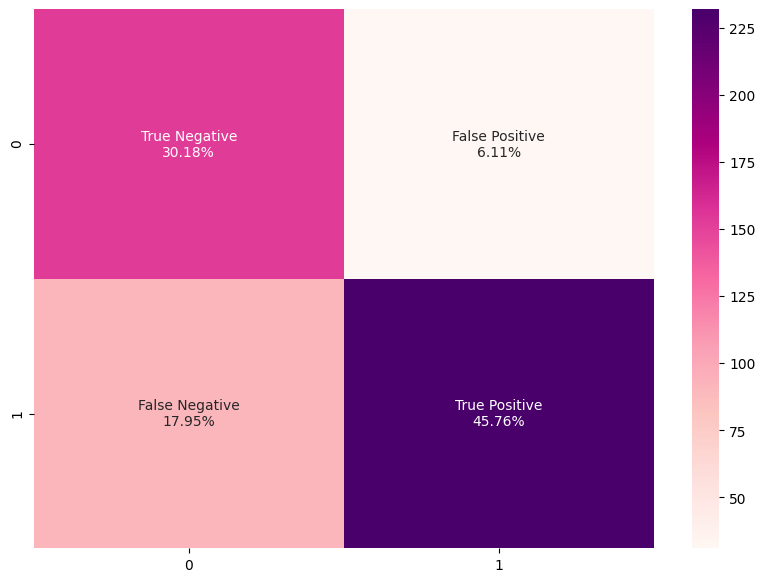

In [288]:
# calculate confusion matrix
confusion_mat_val = confusion_matrix(preds_at_threshold_05, label_list.cpu().numpy())
labels_TF = np.asarray(labels_TF).reshape(2,2)
plt.figure(figsize = (10,7))
sns.heatmap(confusion_mat_val, annot=labels_TF_final, fmt="", cmap='RdPu')

In [289]:
# save results
roc_auc_nn['fpr_'+CHAIN], roc_auc_nn['tpr_'+CHAIN], roc_auc_nn['thresholds_'+CHAIN] = roc_curve(label_list.cpu().numpy(), preds)
roc_auc_nn['roc_auc_'+CHAIN] = auc(roc_auc_nn['fpr_'+CHAIN], roc_auc_nn['tpr_'+CHAIN])

#### Plot Results

In [80]:
dnn_dic_1 = {'DNN_CVC': [70, 69.531, 70],
             'DNN_scCVC': [75.535, 76, 75.326]}

# calculate mean accuracy for each model
res_dnn_avg = {key: np.mean(value) for key, value in dnn_dic_1.items()}
res_dnn_avg

{'DNN_CVC': 69.84366666666666, 'DNN_scCVC': 75.62033333333333}

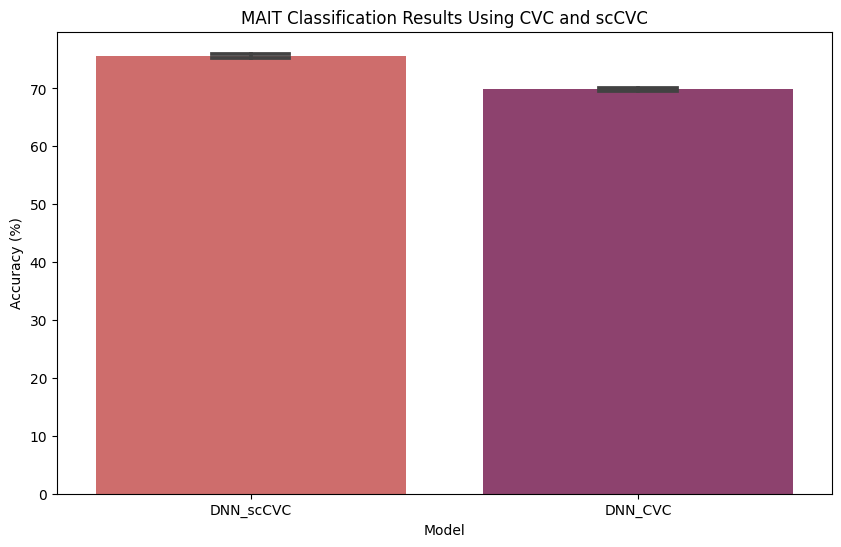

In [81]:
# dictionary
dnn_dic = {'model': ['DNN_CVC', 'DNN_CVC', 'DNN_CVC',
                     'DNN_scCVC', 'DNN_scCVC', 'DNN_scCVC'],
           'accuracy': [70, 69.531, 70, 75.535, 76, 75.326]}

# barplot of accuracy with error bars
df = pd.DataFrame(dnn_dic)
df = df.sort_values(by='accuracy', ascending=False)
df = df.reset_index(drop=True)
df
# plot
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x='model', y='accuracy', data=df, ax=ax, palette="flare", capsize=.2)
ax.set_title('MAIT Classification Results Using CVC and scCVC')
ax.set_ylabel('Accuracy (%)')
ax.set_xlabel('Model')
# ax.set_ylim(85, 100)
# save figure in svg format in high resolution
plt.savefig('./plots/cvc_2.0/accuracy_CVC_scCVC_MAIT.svg', format='svg', dpi=1200)
plt.show()

#### Plot ROC Curve

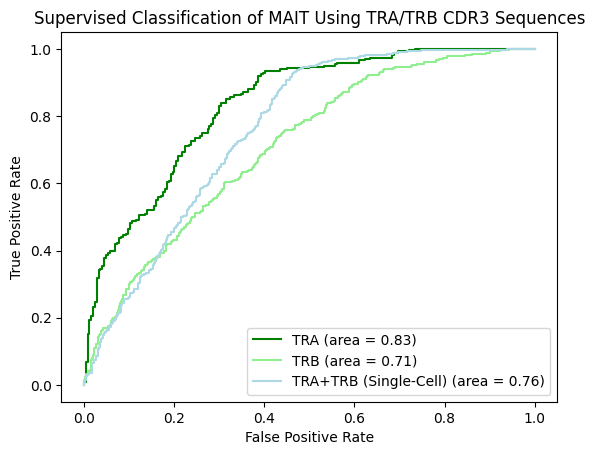

In [292]:
# plot roc curve
plt.plot(roc_auc_nn['fpr_TRA'], roc_auc_nn['tpr_TRA'], color='green',
         label='TRA (area = %0.2f)' % roc_auc_nn["roc_auc_TRA"])
plt.plot(roc_auc_nn['fpr_TRB'], roc_auc_nn['tpr_TRB'], color='lightgreen',
         label='TRB (area = %0.2f)' % roc_auc_nn["roc_auc_TRB"])
plt.plot(roc_auc_nn['fpr_SC'], roc_auc_nn['tpr_SC'], color='lightblue',
         label='TRA+TRB (Single-Cell) (area = %0.2f)' % roc_auc_nn["roc_auc_SC"])
# Set axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# Set title
plt.title('Supervised Classification of MAIT Using TRA/TRB CDR3 Sequences')
# Set plot legend
plt.legend(loc="lower right")
# save figure in svg format in high resolution
plt.savefig('./plots/cvc_2.0/ROC_TRA_TRB_MAIT.svg', format='svg', dpi=1200)
# Show plot
plt.show()